In [1]:
# copy the lib file in the working directory and load it
from shutil import copyfile
copyfile('target/release/libising.so', 'ising.so')
import ising

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import threading
import time

In [3]:
L = 32  # size of the lattice

nn1 = [[((x+1) % L, y), ((x-1) % L, y), (x, (y+1) % L), (x, (y-1) % L)] for y in range(L) for x in range(L)]
nn1 = [[x + L*y for (x,y) in n] for n in nn1]

nn2 = [[((x+1) % L, (y+1) % L), ((x-1) % L, (y+1) % L), ((x+1) % L, (y-1) % L), ((x-1) % L, (y-1) % L)] for y in range(L) for x in range(L)]
nn2 = [[x + L*y for (x,y) in n] for n in nn2]

<IPython.core.display.Javascript object>


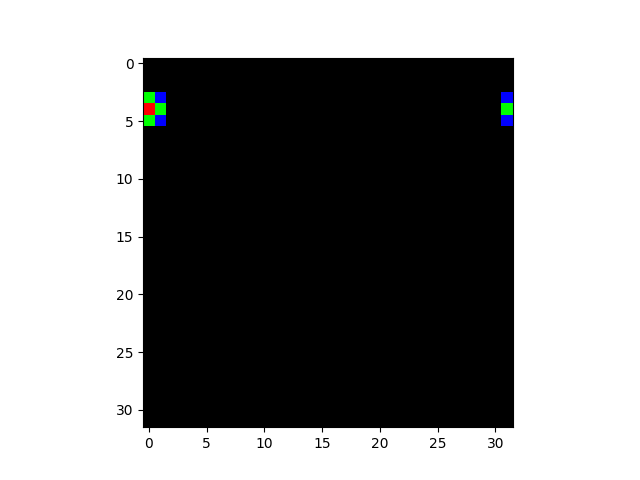

In [4]:
plt.figure()
z = np.zeros((L*L, 3))
i = 4*32
z[i] = [1, 0, 0]
z[nn1[i]] = [0, 1, 0]
z[nn2[i]] = [0, 0, 1]
plt.imshow(z.reshape((L, L, 3)))

In [5]:
H = ising.Hamiltonian([(1, nn1), (-0.1, nn2)])

In [6]:
n = 100  # amount of temperatures / states

# Initialize the states, compute the enegies and attribute their temperatures
xs = [np.random.randint(0, 2, size=(L * L, ), dtype=np.int32) * 2 - 1 for i in range(n)]
es = [H.energy(xs[i]) for i in range(n)]

bs = np.linspace(1/0.05, 1/1.5, n)
ts = 1 / bs

<IPython.core.display.Javascript object>


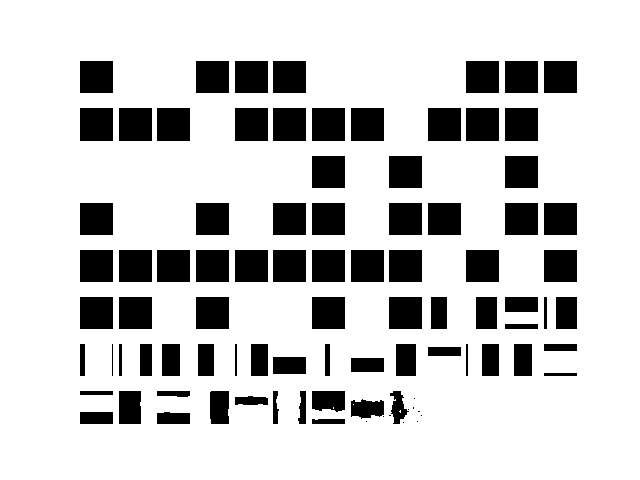

In [7]:
# This cell only makes a plot to show the evolutions of the states in real time

# compute the appropriate amount of plots to do in width
w = int(np.ceil(np.sqrt(1.5 * n)))

# create a new figure and its subplots
fig = plt.figure()
axes = [fig.add_subplot(int(np.ceil(n / w)), w, i + 1) for i in range(n)]

def plot(i):
    axes[i].set_axis_off()
    return axes[i].imshow(xs[i].reshape((L, L)), cmap='gray', vmin=-1, vmax=1)

imgs = [plot(i) for i in range(n)]

fig.canvas.draw()

# this function sets the new data into the figure and redraw it
def replot(xs):
    for i in range(n):
        imgs[i].set_data(xs[i].reshape((L, L)))
    fig.canvas.draw()

In [8]:
# for debug purpose, this function measure the execution time of a portion of code

def top(text=None):
    now = time.time()
    if text:
        print("{} : {:.3f}s".format(text, now - top.past))
    top.past = now
    
top.past = time.time()

In [9]:
# Define a function that perform sweep in parallel then do parallel tempering

def sweep_swap():
    num_threads = 4
    
    # create and run one thread for each temperature
    threads = []
    for i in range(num_threads):
        # define the function that will be run by the thread (it depends on the value of i)
        def sweep():
            # perform a sweep on the states i, i+num_threads, i+2*num_threads, ...
            for j in range(i, n, num_threads):
                es[j] += H.sweep(xs[j], ts[j]) # the sweep returns the delta in energy
        
        t = threading.Thread(target=sweep) # create a new thread
        t.start() # start it
        threads.append(t)

    # wait all threads to finish
    for t in threads:
        t.join()

    # performs swaps
    for _ in range(2 * n):
        #[i, j] = np.random.choice(n, 2, replace=False) # pick randomly i != j
        i = np.random.randint(n - 1)
        j = i + 1
        if np.random.uniform() < np.exp((es[i] - es[j]) * (1 / ts[i] - 1 / ts[j])):
            # swap the states and the energies
            xs[i], xs[j] = xs[j], xs[i]
            es[i], es[j] = es[j], es[i]

In [10]:
top()
# thermalize
for _ in range(1000):
    sweep_swap()

top('termalize')

m = 2000
energy = np.zeros((m, n))
magnet = np.zeros((m, n))

for i in range(m):    
    sweep_swap()
    energy[i] = np.array(es) / (L * L)
    magnet[i] = np.array([np.sum(xs[j]) for j in range(n)]) / (L * L)
    
    if i % 200 == 0:
        top(str(i))
        replot(xs)
        top('plot')

termalize : 6.874s
0 : 0.006s
plot : 0.266s
200 : 2.145s
plot : 0.146s
400 : 1.412s
plot : 0.161s
600 : 1.372s
plot : 0.149s
800 : 1.389s
plot : 0.150s
1000 : 2.109s
plot : 0.170s
1200 : 1.446s
plot : 0.155s
1400 : 1.423s
plot : 0.150s
1600 : 1.424s
plot : 0.148s
1800 : 1.441s
plot : 0.149s


<IPython.core.display.Javascript object>


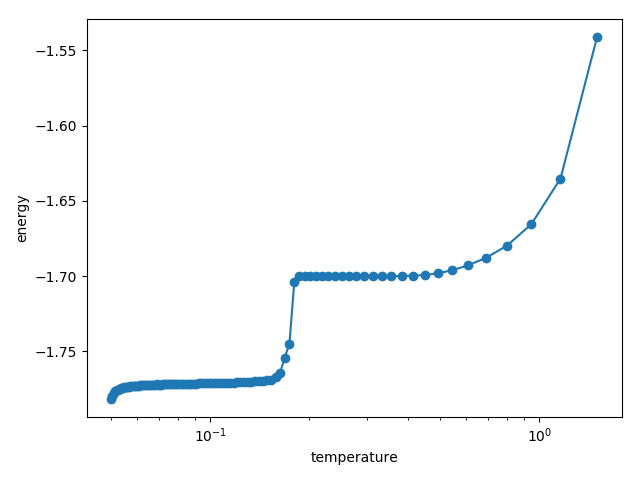

In [11]:
plt.figure()
plt.semilogx(ts, np.mean(energy, 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('energy')
plt.tight_layout()

<IPython.core.display.Javascript object>


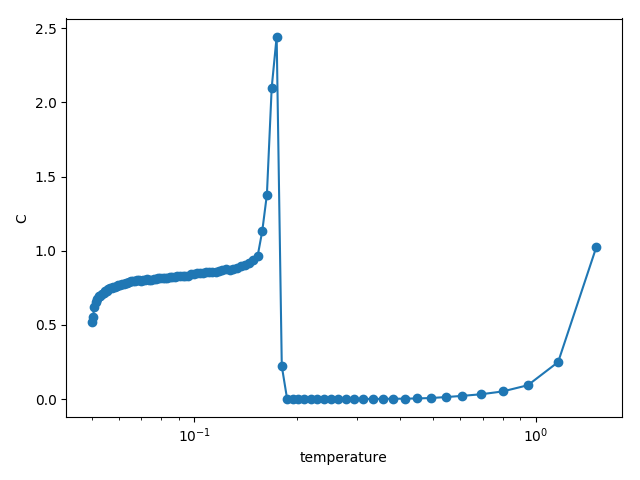

In [12]:
plt.figure()
plt.semilogx(ts, np.var(energy, 0) * L * L, 'o-')
plt.xlabel('temperature')
plt.ylabel('C')
plt.tight_layout()

<IPython.core.display.Javascript object>


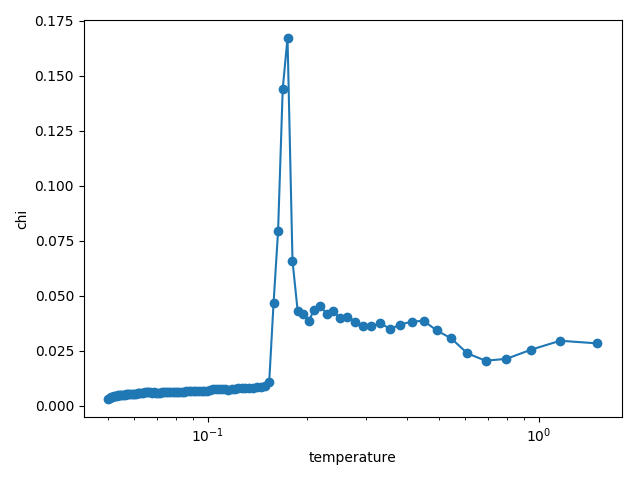

In [13]:
plt.figure()
plt.semilogx(ts, np.var(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('chi')
plt.tight_layout()

<IPython.core.display.Javascript object>


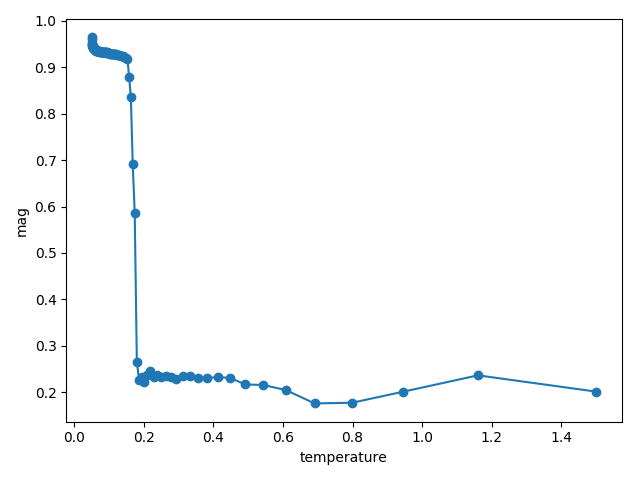

In [14]:
plt.figure()
plt.plot(ts, np.mean(np.abs(magnet), 0), 'o-')
plt.xlabel('temperature')
plt.ylabel('mag')
plt.tight_layout()